# Playing with sample kHz QPO dataset

In [1]:
from astropy.table import Table
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, DynamicalPowerspectrum, Crossspectrum, AveragedCrossspectrum
from astropy.modeling import models, fitting
from stingray.modeling.scripts import fit_powerspectrum, fit_lorentzians
from scipy.stats import binned_statistic

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
lc_fits = Table.read('./toy_kHz_lightcurve.fits')
meta = lc_fits.meta
print(lc_fits.info())
print(meta)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
lc_fits

<Table length=32768>
name  dtype   shape 
---- ------- -------
 REF float64   (20,)
  CI float64 (5, 20)
None
OrderedDict([('N_BINS', 32768), ('DT', 0.00048828125), ('DETCHANS', 5), ('CHBIN', '/Users/abbie/Dropbox/Research/kHz_QPO_phase_res/toy_chbinfile.txt'), ('N_SEG', 20), ('NSECONDS', 16)])


REF [20],"CI [5,20]"
float64,float64
2048.0 .. 0.0,0.0 .. 0.0
2048.0 .. 4096.0,0.0 .. 0.0
0.0 .. 0.0,0.0 .. 0.0
6144.0 .. 0.0,0.0 .. 0.0
2048.0 .. 4096.0,0.0 .. 0.0
4096.0 .. 0.0,0.0 .. 0.0
6144.0 .. 4096.0,0.0 .. 0.0
2048.0 .. 2048.0,0.0 .. 0.0
0.0 .. 2048.0,0.0 .. 0.0


In [3]:
# multiply dt to get counts
ref = np.asarray(lc_fits['REF'].T * dt, dtype=np.float64)
ci = np.asarray(lc_fits['CI'].T * dt, dtype=np.float64)
times = np.arange(0, n_seconds*n_seg, dt)
print(ref.shape, ci.shape, times.shape)

# get counts in ref and ci bands
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape, times.shape)

(20, 32768) (20, 5, 32768) (655360,)
(655360,) (5, 655360) (655360,)


## What I learned about the dataset
Given dataset has:-
-  2 sets of lightcurves (REF and CI)
-  5 channels of interest
-  32768 bins of photon energy
-  20 sequential segments
-  'count rate' as unit

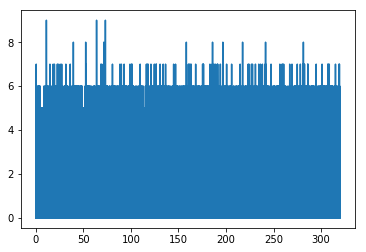

In [4]:
# taking all segments
counts = np.hstack(ref)
# print(times)
lc = Lightcurve(times, counts, dt=dt)
lc.plot()


Old dt:  0.00048828125
New dt:  8


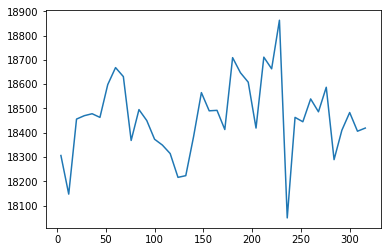

In [5]:
lc_rebin = lc.rebin(8)
print("Old dt: ", lc.dt)
print("New dt: ", lc_rebin.dt)
lc_rebin.plot()

## Powerspectrum, AveragedPowerspectrum and DynamicalPowerspectrum

A Powerspectrum object has the following properties :
    -  freq : Numpy array of mid-bin frequencies that the Fourier transform samples.
    -  power : Numpy array of the power spectrum.
    -  df : The frequency resolution.
    -  m : The number of power spectra averaged together. For a Powerspectrum of a single segment, m=1.
    -  n : The number of data points (time bins) in one segment of the light curve.
    -  nphots1 : The total number of photons in the light curve.


26.537528840953623


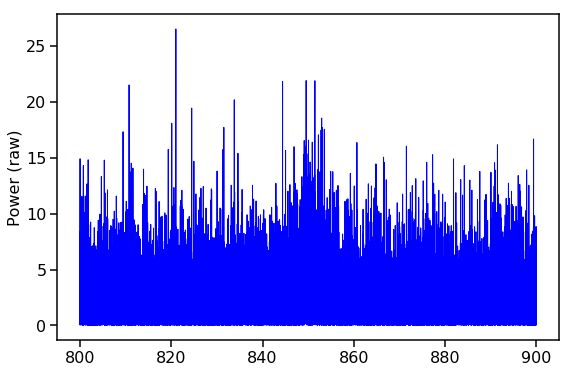

In [6]:
ps = Powerspectrum(lc, norm='leahy')

# print(len(ps.freq))
# print(ps.freq)
# print(ps.power)
# print(ps.df)
# print(ps.m)
# print(ps.n)
# print(ps.nphots1)

print(max(ps.power))

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(ps.freq[int(800/1024*len(ps.freq)):int(900/1024*len(ps.freq))], ps.power[int(800/1024*len(ps.freq)):int(900/1024*len(ps.freq))], lw=1, color='blue')
ax1.set_ylabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

0.003125
0.0625


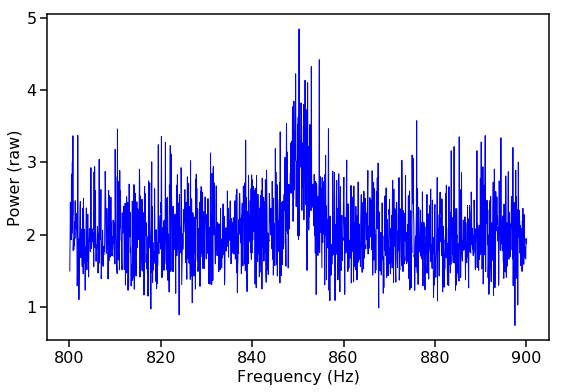

In [7]:
segment_size = n_seconds
avg_ps = AveragedPowerspectrum(lc, segment_size=segment_size, norm='leahy')
print(ps.df)
print(avg_ps.df)

range_start = 800 * segment_size
range_stop = 900 * segment_size

fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(avg_ps.freq[range_start:range_stop], avg_ps.power[range_start:range_stop], lw=1, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

In [8]:
p_freq = avg_ps.freq # Positive Fourier frequencies
print("Old df: %.4f Hz" % (p_freq[1]-p_freq[0]))
lin_psd, f_bin_edges, something = binned_statistic(p_freq, avg_ps.power[0:int(avg_ps.n/2+1)], 
                            statistic='mean', bins=1600)
new_df = np.median(np.diff(f_bin_edges))
print("New df: %.2f Hz" % new_df)
lin_pfreq = f_bin_edges[0:-1]+0.5*new_df  # so that the frequency is mid-bin

Old df: 0.0625 Hz
New df: 0.64 Hz


1600
655360


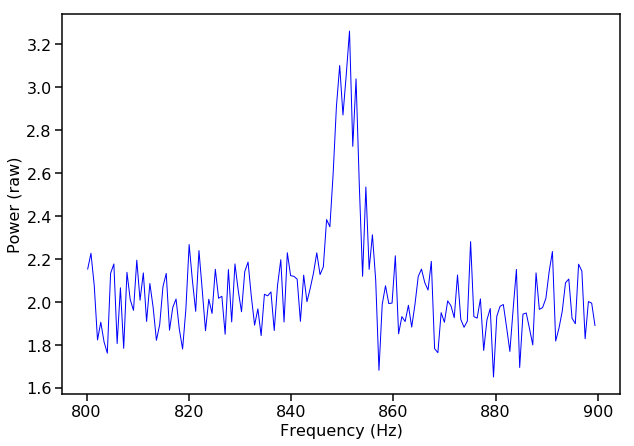

In [9]:
avg_ps_rebin = ps.rebin(df=new_df)
n = len(avg_ps_rebin.freq)
print(n)
print(avg_ps_rebin.n)

range_start = int(800 * n / 1024)
range_stop = int(900 * n / 1024)


fig, ax1 = plt.subplots(1,1,figsize=(10,7))
ax1.plot(avg_ps_rebin.freq[range_start:range_stop], avg_ps_rebin.power[range_start:range_stop], lw=1, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
# ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

In [10]:
dyn_ps = DynamicalPowerspectrum(lc, segment_size=segment_size, norm='leahy')

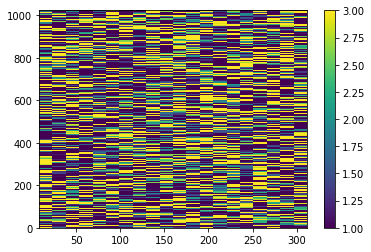

In [11]:
plt.imshow(dyn_ps.dyn_ps, aspect="auto", vmin=1, vmax=3, origin="lower",
          extent=[min(dyn_ps.time), max(dyn_ps.time), min(dyn_ps.freq), max(dyn_ps.freq)])
plt.colorbar()

In [12]:
dyn_ps_rebin = dyn_ps.rebin_frequency(new_df, method='mean')

(600, 900)

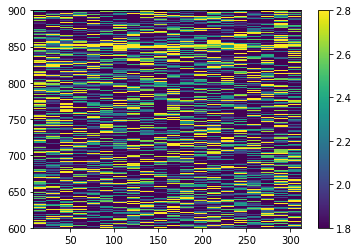

In [13]:
plt.imshow(dyn_ps.dyn_ps, aspect="auto", vmin=1.8, vmax=2.8, origin="lower",
           extent=[min(dyn_ps.time), max(dyn_ps.time), min(dyn_ps.freq), max(dyn_ps.freq)])
plt.colorbar()
plt.ylim(600,900)

In [14]:
dyn_ps.rebin_time(dt_new=dyn_ps.dt*3, method="mean")

(600, 900)

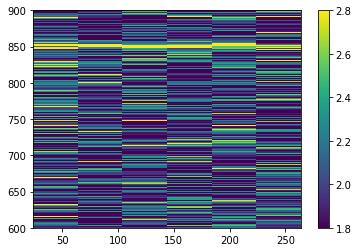

In [15]:
plt.imshow(dyn_ps.dyn_ps, aspect="auto", vmin=1.8, vmax=2.8, origin="lower",
          extent=[min(dyn_ps.time), max(dyn_ps.time), min(dyn_ps.freq), max(dyn_ps.freq)])
plt.colorbar()
plt.ylim(600,900)

In [16]:
pos = dyn_ps.trace_maximum(min_freq=800, max_freq=900)

In [17]:
dyn_ps.freq[pos]

array([850.80738281, 849.52753906, 848.88761719, 850.16746094,
       851.44730469, 852.08722656])

(700, 900)

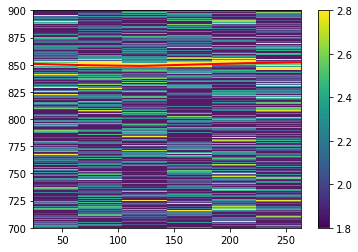

In [18]:
plt.imshow(dyn_ps.dyn_ps, aspect="auto", vmin=1.8, vmax=2.8, origin="lower",
          extent=[min(dyn_ps.time), max(dyn_ps.time), min(dyn_ps.freq), max(dyn_ps.freq)],
          alpha=0.9)
plt.colorbar()
plt.plot(dyn_ps.time, dyn_ps.freq[pos], 'r', lw=2)
plt.ylim(700,900)

In [19]:
1/(n_bins*dt)

0.0625

# Fitting model

Model: CompoundModel0
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Lorentz1D(amplitude=1., x_0=851.41761719, fwhm=1.)>

    [1]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>
Parameters:
    amplitude_0       x_0_0       fwhm_0 amplitude_1 x_0_1 alpha_1
    ----------- ----------------- ------ ----------- ----- -------
            1.0 851.4176171875363    1.0         1.0   1.0     1.0


/anaconda3/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


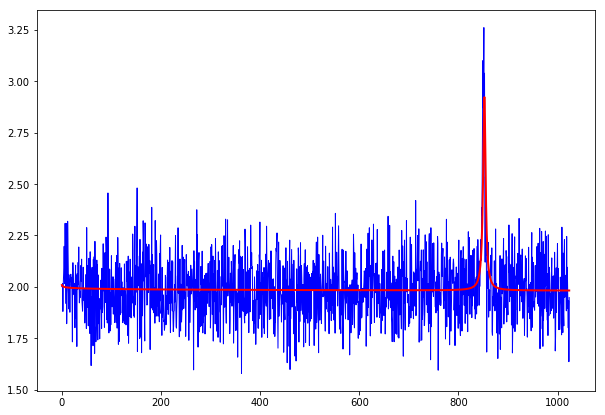

In [20]:
max_freq_index = np.argmax(avg_ps_rebin.power)
x_0 = avg_ps_rebin.freq[max_freq_index]
model = models.Lorentz1D(x_0=x_0, bounds={"x_0": [x_0+1, x_0+2]}) + models.PowerLaw1D()
print(model)

fitter = fitting.LevMarLSQFitter()
fit_fn = fitter(model, avg_ps_rebin.freq, avg_ps_rebin.power)
fit = fit_fn(avg_ps_rebin.freq)
# plotting
plt.figure(figsize=(10,7))
plt.plot(avg_ps_rebin.freq, avg_ps_rebin.power, lw=1, color='blue')
plt.plot(avg_ps_rebin.freq, fit, lw=2, color="red")

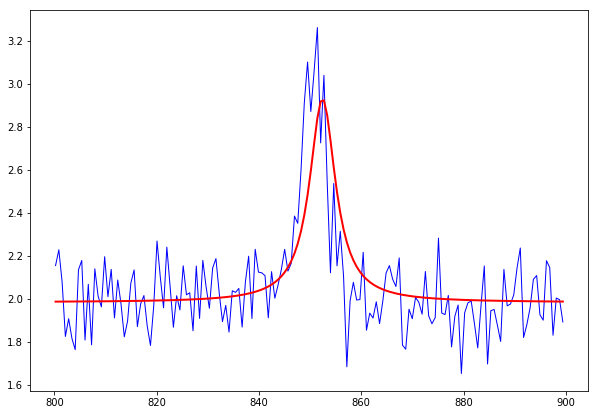

In [21]:
range_start = int(800 * n / 1024)
range_stop = int(900 * n / 1024)


fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(avg_ps_rebin.freq[range_start:range_stop], avg_ps_rebin.power[range_start:range_stop], lw=1, color='blue')
plt.plot(avg_ps_rebin.freq[range_start:range_stop], fit[range_start:range_stop], lw=2, color="red")

# Cross spectrum

/anaconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


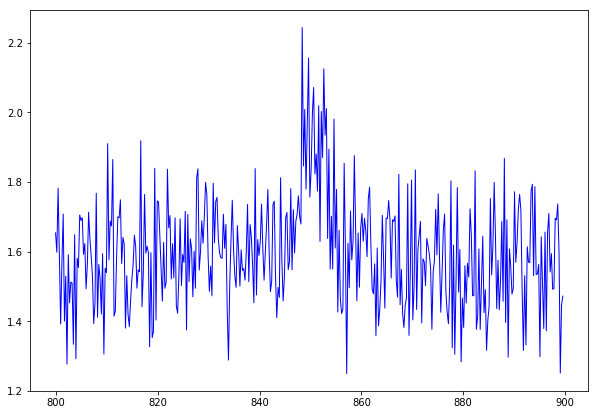

In [25]:
times = np.arange(0, n_seconds*n_seg, dt)
lc1 = Lightcurve(times, ref_counts, dt=dt)
lc2 = Lightcurve(times, ci_counts[1], dt=dt)

cs1 = Crossspectrum(lc1=lc1, lc2=lc2, norm='leahy', amplitude=True)
cs1 = cs1.rebin(0.25) # rebinning

n = len(cs1.freq)
range_start, range_stop = int(800 * n / 1024), int(900 * n / 1024)
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(cs1.freq[range_start:range_stop], np.abs(cs1.power)[range_start:range_stop], lw=1, color='blue') # used `abs` as suggested by Abigail

/anaconda3/lib/python3.6/site-packages/stingray-0.1rc1-py3.6.egg/stingray/utils.py:89: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


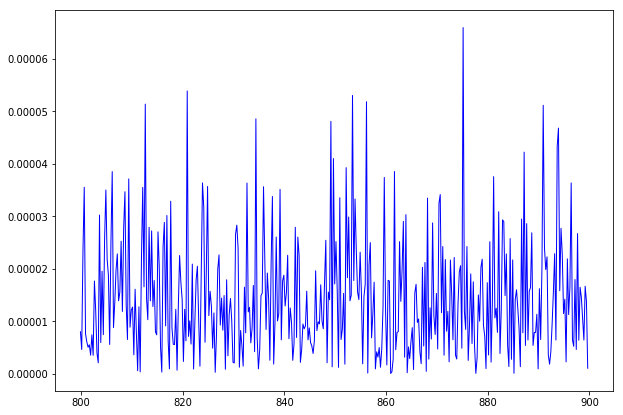

In [23]:
avg_cs1 = AveragedCrossspectrum(lc1=lc1, lc2=lc2, segment_size=segment_size, norm='abs')
avg_cs1 = avg_cs1.rebin(0.25) #rebinning

n = len(avg_cs1.freq)
range_start = int(800 * n / 1024)
range_stop = int(900 * n / 1024)

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(avg_cs1.freq[range_start:range_stop], np.abs(avg_cs1.power)[range_start:range_stop], lw=1, color='blue') # used `abs` as suggested by Abigail

# Cross spectrum fitting

Model: CompoundModel5
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Lorentz1D(amplitude=1., x_0=848.3765625, fwhm=1.)>

    [1]: <PowerLaw1D(amplitude=1., x_0=1., alpha=1.)>
Parameters:
    amplitude_0    x_0_0    fwhm_0 amplitude_1 x_0_1 alpha_1
    ----------- ----------- ------ ----------- ----- -------
            1.0 848.3765625    1.0         1.0   1.0     1.0


/anaconda3/lib/python3.6/site-packages/astropy/modeling/powerlaws.py:53: RuntimeWarning: invalid value encountered in power
  return amplitude * xx ** (-alpha)


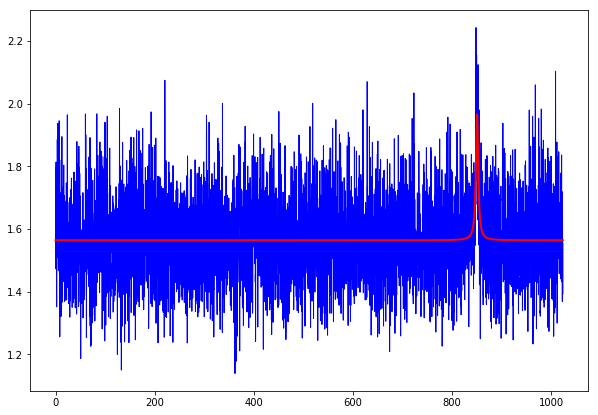

In [33]:
max_freq_index = np.argmax(cs1.power)
x_0 = cs1.freq[max_freq_index]
model = models.Lorentz1D(x_0=x_0, bounds={"x_0": [x_0-10, x_0+10]}) + models.PowerLaw1D()
print(model)

fitter = fitting.LevMarLSQFitter()
fit_fn = fitter(model, cs1.freq, cs1.power)
fit = fit_fn(cs1.freq)
# plotting
plt.figure(figsize=(10,7))
plt.plot(cs1.freq, cs1.power, lw=1, color='blue')
plt.plot(cs1.freq, fit, lw=2, color="red")

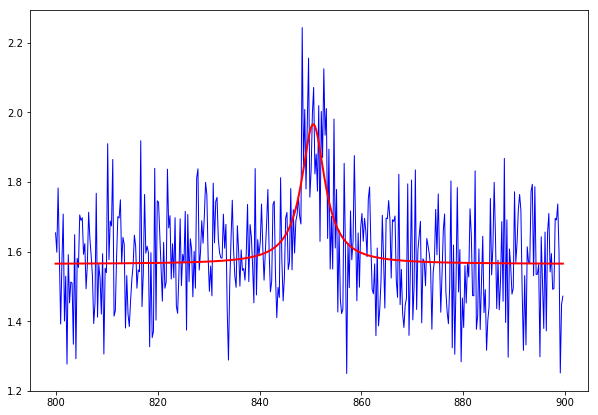

In [34]:
# plotting
n = len(cs1.freq)
range_start = int(800 * n / 1024)
range_stop = int(900 * n / 1024)

plt.figure(figsize=(10,7))
plt.plot(cs1.freq[range_start:range_stop], cs1.power[range_start:range_stop], lw=1, color='blue')
plt.plot(cs1.freq[range_start:range_stop], fit[range_start:range_stop], lw=2, color="red")